# Setup

In [1]:
from io import open
import glob
import os
import time
import torch
from torch.utils.data import Dataset

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {device}")

Using device = cpu


In [2]:
print("Pytorch version:", torch.__version__)
!python -V

Pytorch version: 2.2.2
Python 3.11.0


# Preparing the Data

In [3]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
print("Allowed characters:", allowed_characters)
n_letters = len(allowed_characters)
print("Number of allowed characters:", n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

Allowed characters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'_
Number of allowed characters: 58


In [4]:
print (f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")

converting 'Ślusàrski' to Slusarski


# Turning Names into Tensors

In [5]:
letter = 'b'
allowed_characters.find(letter)

1

In [6]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [7]:
print (f"The letter 'a' becomes {lineToTensor('a')}") #notice that the first position in the tensor = 1
print (f"The name 'Ahn' becomes {lineToTensor('Ahn')}") #notice 'A' sets the 27th index to 1

The letter 'a' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])
The name 'Ahn' becomes tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [8]:
lineToTensor('Ahn').shape

torch.Size([3, 1, 58])

In [9]:
class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir # for provenance of the dataset
        self.load_time = time.localtime # for provenance of the dataset
        labels_set = set() # set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        # Read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        # Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [10]:
alldata = NamesDataset("./data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([13]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]]), 'Czech', 'Abl')


In [11]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


# Creating the Network

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [13]:
print("Num of classes:  ", len(alldata.labels_uniq))

Num of classes:   18


In [14]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [15]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.7949, -3.0614, -2.7849, -2.8142, -2.8624, -3.0399, -2.8204, -2.8998,
         -2.9631, -2.7998, -2.8745, -2.7831, -2.9084, -2.9838, -2.9743, -2.9491,
         -2.8122, -2.9700]], grad_fn=<LogSoftmaxBackward0>)
('Greek', 11)


# Training

## Training the Network

In [16]:
import random
import numpy as np

def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [17]:
start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end = time.time()
print(f"training took {end-start}s")

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.8965954201148382
10 (37%): 	 average batch loss = 0.7046683853282067
15 (56%): 	 average batch loss = 0.5911815870016761
20 (74%): 	 average batch loss = 0.5058234363466829
25 (93%): 	 average batch loss = 0.4495723868300627
training took 497.78008580207825s


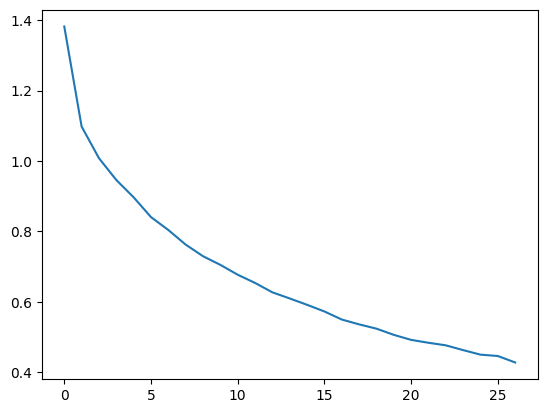

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

# Evaluating the Results

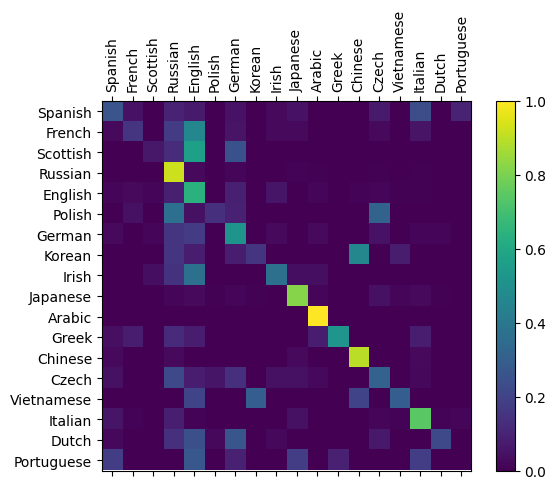

In [19]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_uniq)